# 1. Load Packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

In [23]:
postanalysis_folder = r'P:\MERFISH_Analysis\Merged_MOP'
print(postanalysis_folder)
dark_mode = True
if dark_mode:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0903_dark')
    plt.style.use('dark_background')
else:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0817')
print(figure_folder)
    
    
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white', transparent=True)
sc.settings.figdir = figure_folder

P:\MERFISH_Analysis\Merged_MOP
P:\MERFISH_Analysis\Merged_MOP\Figures_0903_dark


# 2. Load labled RNA MERFISH data and add class labels

In [5]:
merged_adata = sc.read(os.path.join(postanalysis_folder, 'manual_labeled_data.h5ad'))

In [10]:
adata_ori = merged_adata
adata_ori

AnnData object with n_obs × n_vars = 62709 × 242
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'experiment', 'n_genes_by_counts', 'total_counts', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_subclass', 'subclass_prediction_label', 'leiden_subclass_sub', 'subclass_manual_label', 'subclass_manual_label_predict'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'experiment_colors', 'leiden', 'leiden_colors', 'leiden_subclass_colors', 'leiden_subclass_sub_colors', 'log1p', 'neighbors', 'pca', 'scrublet', 'subclass_manual_label_colors', 'subclass_prediction_label_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

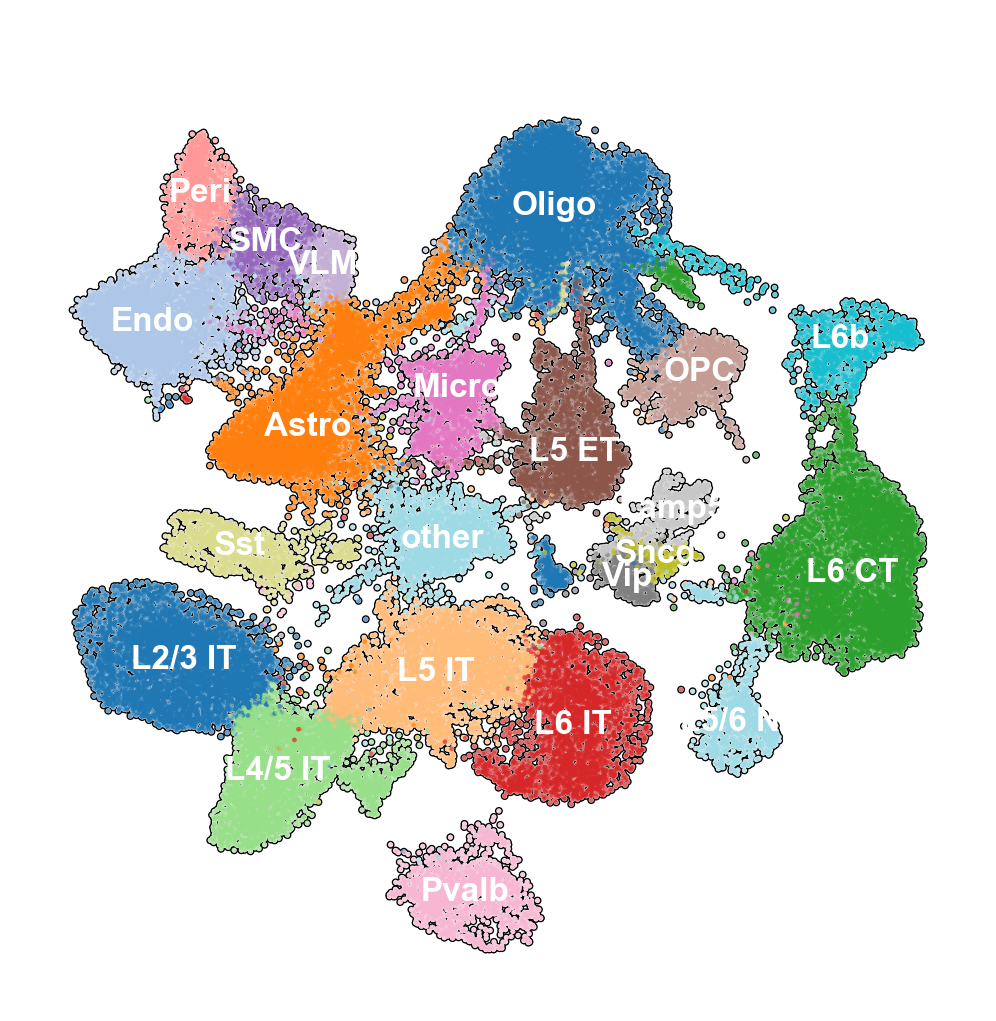

In [30]:
ax = sc.pl.umap(adata_ori, 
           color='subclass_manual_label', legend_loc='on data', size=5, add_outline=True,
           palette='tab20', legend_fontsize=8, #outline_color='black',
           save='_manual_subclass.png')


In [28]:
ax

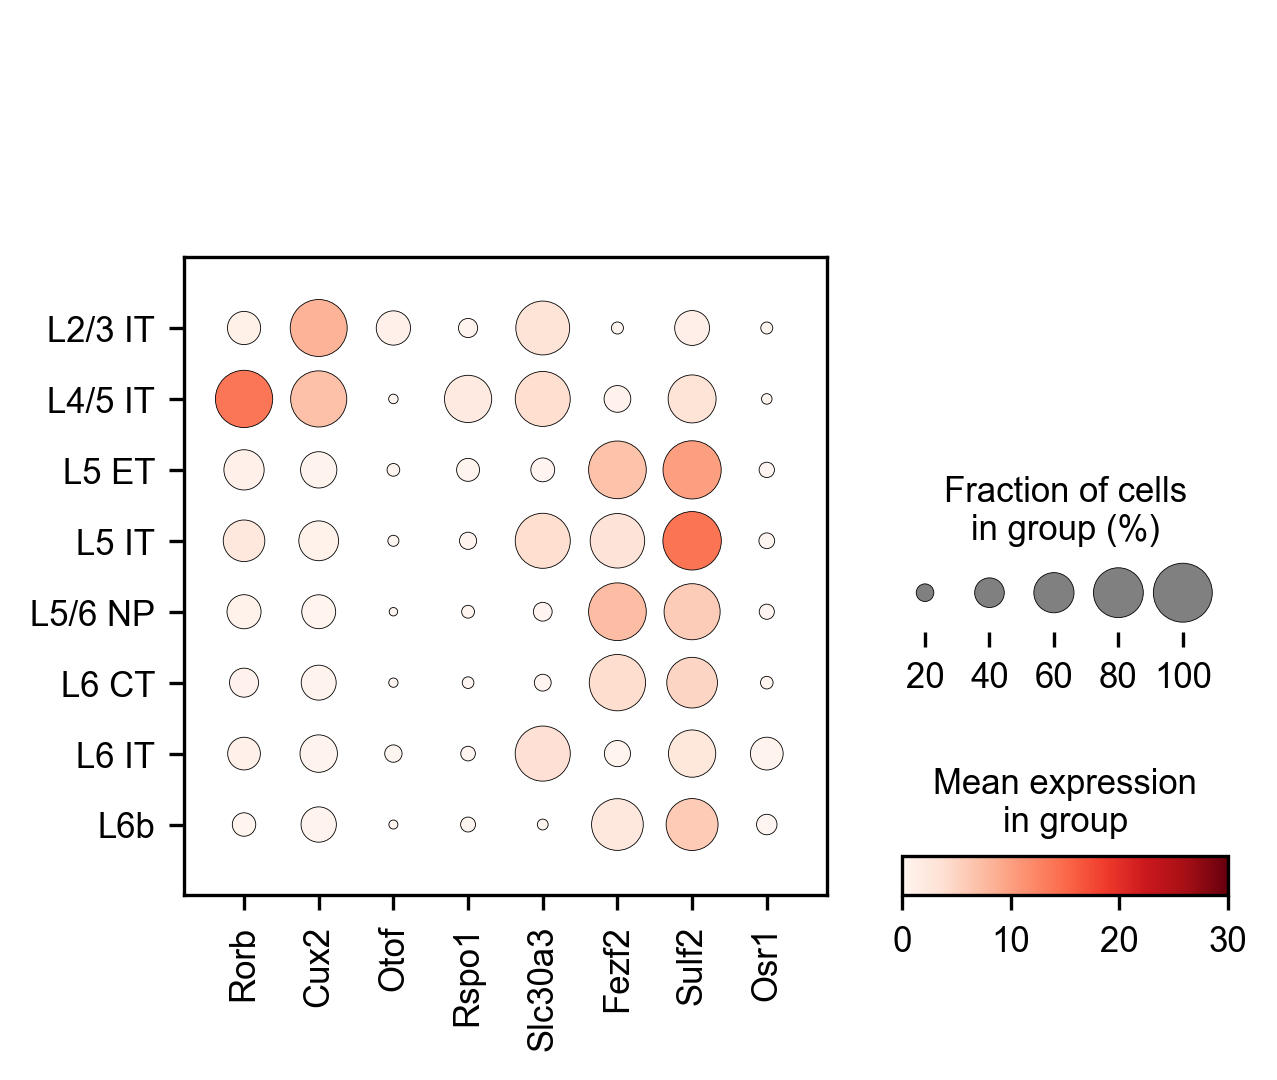

In [44]:
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=10, facecolor='white', transparent=True)

marker_genes_dict = ['Rorb', 'Cux2','Otof','Rspo1','Slc30a3','Fezf2','Sulf2','Osr1']

adata_sel = adata_ori[adata_ori.obs['subclass_manual_label'].str.contains('L')]
adata_sel = adata_sel[~adata_sel.obs['subclass_manual_label'].str.contains('Lamp5')]
adata_sel = adata_sel[~adata_sel.obs['subclass_manual_label'].str.contains('VLMC')]


sc.pl.dotplot(adata_sel, marker_genes_dict, 'subclass_manual_label', dendrogram=False,vmin=0, vmax=30)

## Duplicate the manual label col as 'subclass_label_new' for omic data consistency

In [22]:
merged_adata.obs['subclass_label_new']  = merged_adata.obs['subclass_manual_label'] 

np.unique(merged_adata.obs['subclass_label_new'] )

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'Peri',
       'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip', 'other'],
      dtype=object)

## Merge some 'subclass_label_new' to 'class_label_new'

In [23]:
new_class_dict = {}

for _class in ['L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP','L6 CT', 'L6 IT', 'L6b']:
    new_class_dict[_class]='Gluta'
    
for _class in ['Lamp5','Pvalb', 'Sncg', 'Sst', 'Vip']:
    new_class_dict[_class]='GABA'
    
for _class in ['OPC','Oligo']:
    new_class_dict[_class]='Oligo'
    
for _class in ['Astro']:
    new_class_dict[_class]='Astro'
    
for _class in ['Micro']:
    new_class_dict[_class]='Micro'
    
for _class in ['Endo']:
    new_class_dict[_class]='Endo'
    

# re-label subclass based on Cux2 and Rorb expression level

new_class_label_dict ={'class_label_new':new_class_dict}

# duplicate the column for manual labeling of the final classes
merged_adata.obs['class_label_new'] = merged_adata.obs['subclass_label_new'] 
merged_adata.obs = merged_adata.obs.replace(new_class_label_dict) 

np.unique(merged_adata.obs['class_label_new'] )

array(['Astro', 'Endo', 'GABA', 'Gluta', 'Micro', 'Oligo', 'Peri', 'SMC',
       'VLMC', 'other'], dtype=object)

## Merge some 'class_label_new' to 'neuron_identity'

In [25]:
# re-label subclass based on Cux2 and Rorb expression level

new_class_dict = {}

for _class in ['Gluta','GABA']:
    new_class_dict[_class]='Neuronal'
    
for _class in ['Astro', 'Endo','Micro','Oligo', 'Peri', 'SMC',
       'VLMC',]:
    new_class_dict[_class]='Non-Neuronal'
    

new_class_label_dict ={'neuron_identity':new_class_dict}

# duplicate the column for manual labeling of the final classes
merged_adata.obs['neuron_identity'] = merged_adata.obs['class_label_new'] 
merged_adata.obs = merged_adata.obs.replace(new_class_label_dict)

np.unique(merged_adata.obs['neuron_identity'] )

array(['Neuronal', 'Non-Neuronal', 'other'], dtype=object)

# 3. Show celltypes

by comparing two UMAP above, we could estimate which cluster should be further splitted

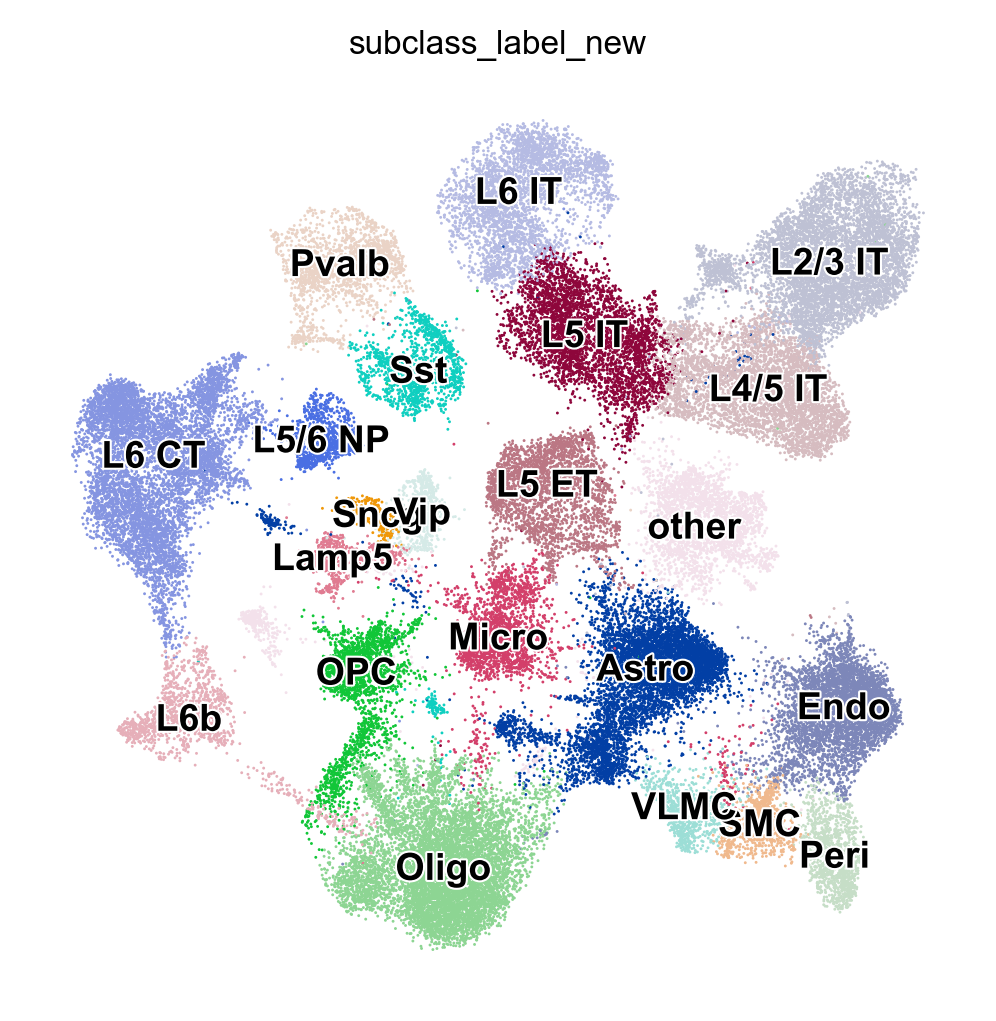

In [27]:
sc.pl.umap(merged_adata, color=['subclass_label_new'], legend_loc='on data',legend_fontsize=9,legend_fontoutline=1)

## Check experiment reprodcibility

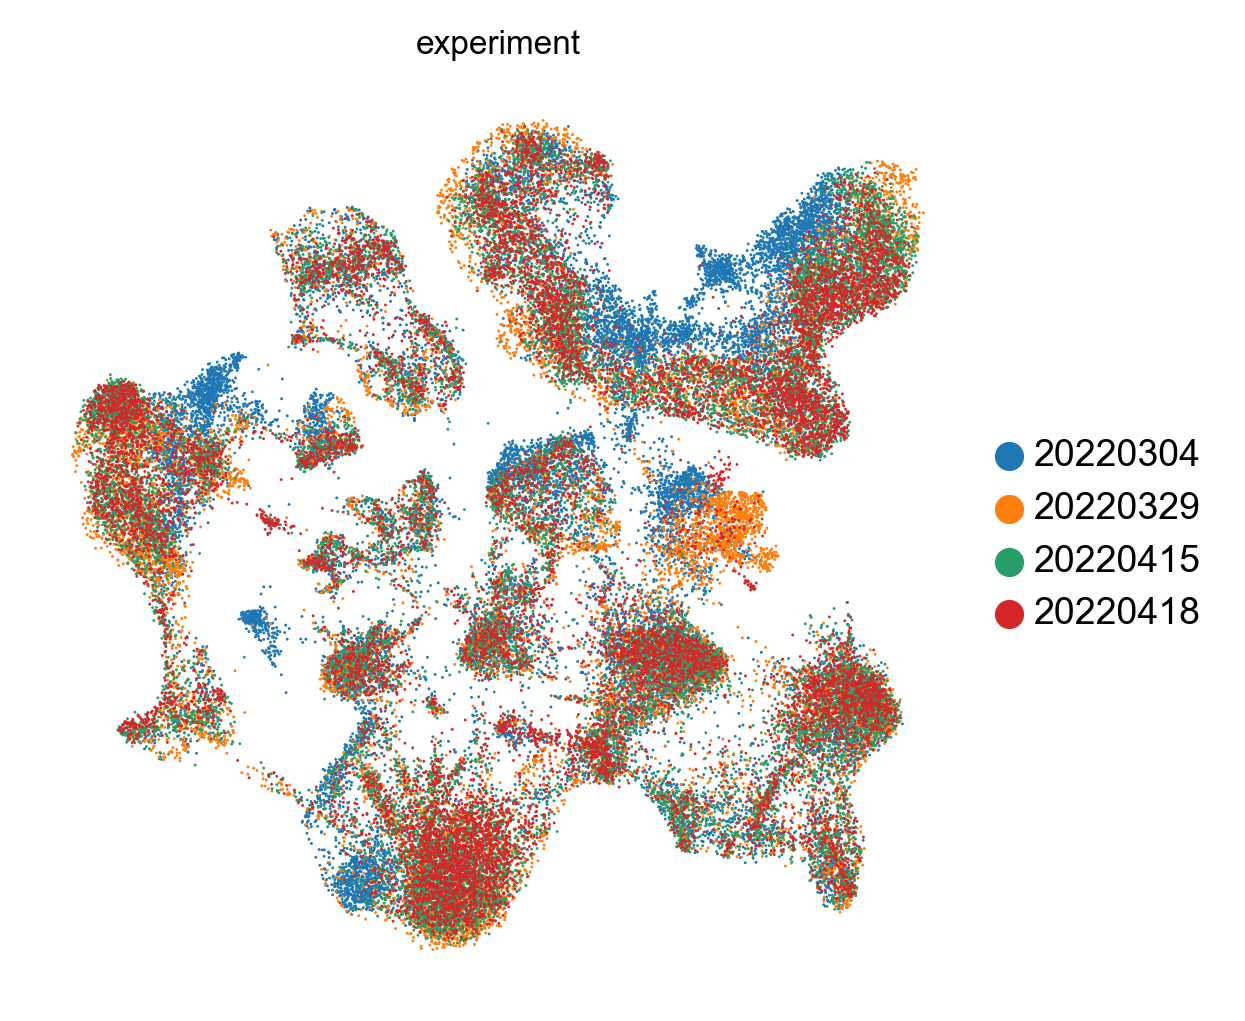

In [29]:
sc.pl.umap(merged_adata, color=['experiment'],legend_fontsize=9,legend_fontoutline=0.5)

## Check cell percentage

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
merged_adata.obs.head()

fov       volume     center_x  \
Unnamed: 0                                                               
103489270985795086009915676188840872439    0   403.121799 -5984.643199   
113811790893231448949429397438012891173    0  1345.443053 -6046.845801   
119547840309256440899855144626134392385    0   866.273544 -6009.207800   
120849314423504941338008541020153695260    0  1186.181156 -6114.885802   
125550627244524118102850004242680097855    0   281.811702 -6190.485804   

                                            center_y        min_x  \
Unnamed: 0                                                          
103489270985795086009915676188840872439  3962.926100 -5989.562599   
113811790893231448949429397438012891173  3943.378100 -6056.090601   
119547840309256440899855144626134392385  3915.406099 -6014.078600   
120849314423504941338008541020153695260  3938.572100 -6122.942603   
125550627244524118102850004242680097855  3985.876101 -6194.546605   

                                               max_x        min_y  \
Unnamed: 0                                                          
103489270985795086009915676188840872439 -5979.723799  3956.597300   
113811790893231448949429397438012891173 -6037.601000  3938.129300   
119547840309256440899855144626134392385 -6004.337000  3910.049299   
120849314423504941338008541020153695260 -6106.829002  3933.377300   
125550627244524118102850004242680097855 -6186.425004  3981.869301   

                                               max_y experiment  \
Unnamed: 0                                                        
103489270985795086009915676188840872439  3969.254901   20220304   
113811790893231448949429397438012891173  3948.626900   20220304   
119547840309256440899855144626134392385  3920.762899   20220304   
120849314423504941338008541020153695260  3943.766900   20220304   
125550627244524118102850004242680097855  3989.882901   20220304   

                                         n_genes_by_counts  ...  \
Unnamed: 0                                                  ...   
103489270985795086009915676188840872439                 27  ...   
113811790893231448949429397438012891173                 52  ...   
119547840309256440899855144626134392385                 33  ...   
120849314423504941338008541020153695260                 71  ...   
125550627244524118102850004242680097855                 14  ...   

                                         predicted_doublet  leiden  \
Unnamed: 0                                                           
103489270985795086009915676188840872439              False       2   
113811790893231448949429397438012891173              False      10   
119547840309256440899855144626134392385              False      10   
120849314423504941338008541020153695260              False      10   
125550627244524118102850004242680097855              False       8   

                                         leiden_subclass  \
Unnamed: 0                                                 
103489270985795086009915676188840872439                2   
113811790893231448949429397438012891173               10   
119547840309256440899855144626134392385               10   
120849314423504941338008541020153695260               10   
125550627244524118102850004242680097855                8   

                                        subclass_prediction_label  \
Unnamed: 0                                                          
103489270985795086009915676188840872439                     Astro   
113811790893231448949429397438012891173                     Oligo   
119547840309256440899855144626134392385                       L6b   
120849314423504941338008541020153695260                     Micro   
125550627244524118102850004242680097855                      Peri   

                                        leiden_subclass_sub  \
Unnamed: 0                                                    
103489270985795086009915676188840872439                   2   
11381179089323144894942939743

In [54]:
_label
np.where(_label)[0][0]

0

In [58]:
sorted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','other']

types, counts = np.unique(merged_adata.obs['subclass_label_new'], return_counts=True)


cellgroup_num_dict = {}
for _label in sorted_labels:
    if _label in types:
        cellgroup_num_dict[_label]= counts[np.where(types==_label)[0][0]]
        
cellgroup_num_dict

{'Lamp5': 643,
 'Sncg': 248,
 'Vip': 631,
 'Sst': 1307,
 'Pvalb': 1802,
 'L2/3 IT': 6035,
 'L4/5 IT': 4217,
 'L5 IT': 3775,
 'L6 IT': 3281,
 'L5 ET': 2629,
 'L5/6 NP': 991,
 'L6 CT': 6944,
 'L6b': 1275,
 'Astro': 6473,
 'OPC': 2366,
 'Oligo': 7806,
 'Endo': 4617,
 'VLMC': 843,
 'SMC': 729,
 'Peri': 1161,
 'Micro': 2240,
 'other': 2719}

<ipython-input-76-5c13841a7037>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cellgroup_num_dict.keys(), rotation=65,fontsize=12)
<ipython-input-76-5c13841a7037>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


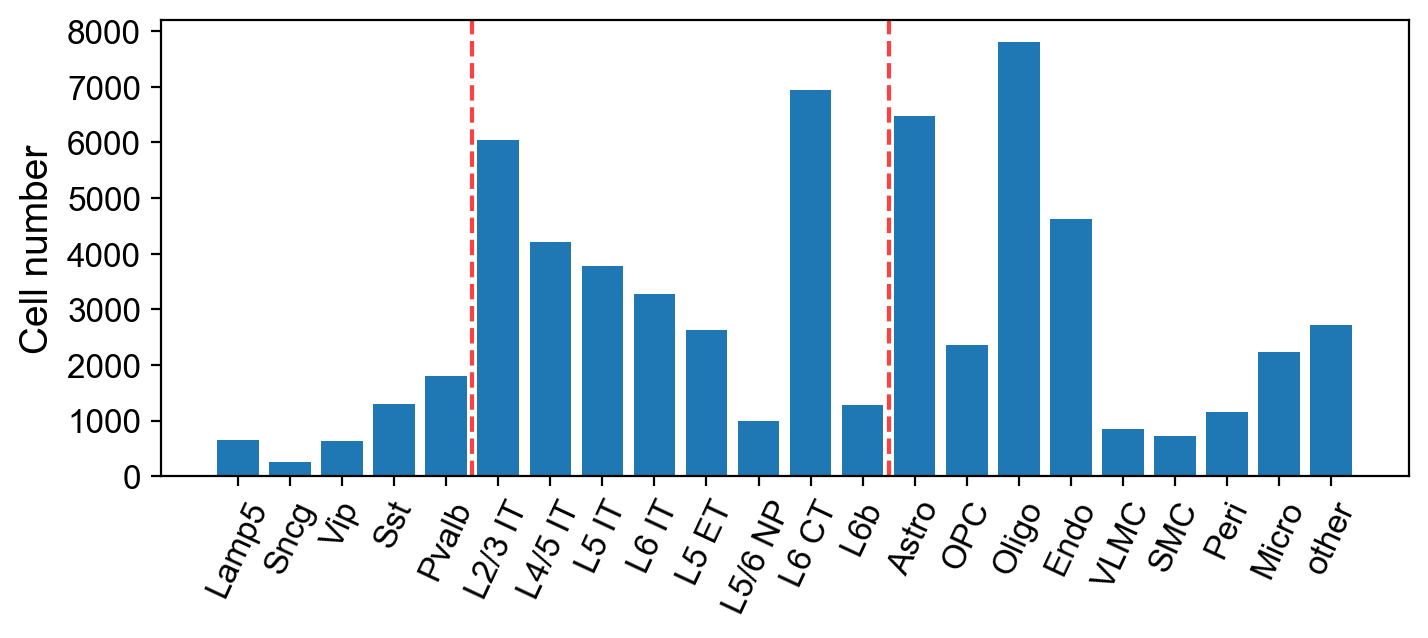

In [76]:

# print class number
fig, ax = plt.subplots(figsize=(8,3), dpi=100)
ax.bar(cellgroup_num_dict.keys(),cellgroup_num_dict.values())
ax.set_xticklabels(cellgroup_num_dict.keys(), rotation=65,fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel('Cell number',fontsize=14)
plt.axvline(x=4.5, color='r', linestyle='--',alpha=0.75)
plt.axvline(x=12.5, color='r', linestyle='--',alpha=0.75)
ax.grid(False)
fig.show()

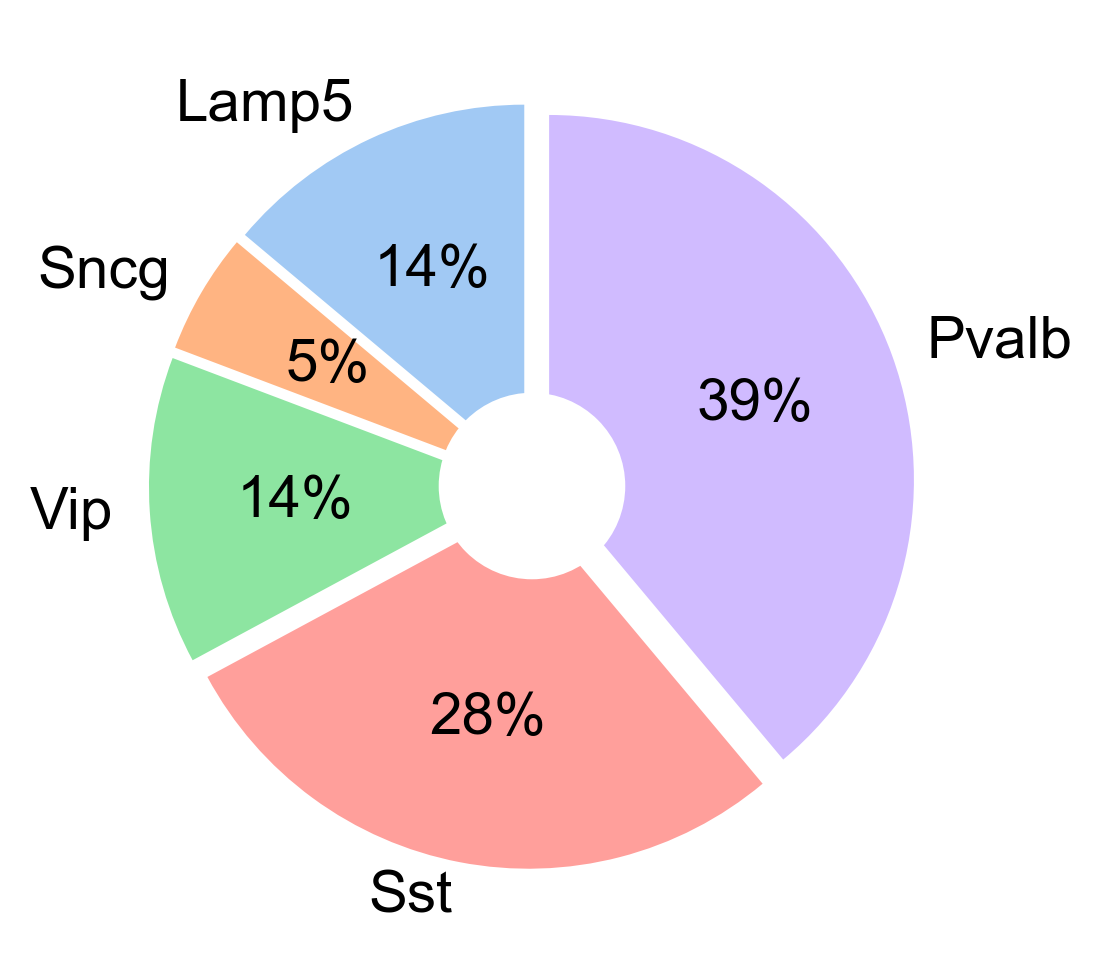

In [108]:
# 

cell_to_plot = ['Lamp5','Sncg','Vip','Sst','Pvalb']


cell_num = [cellgroup_num_dict[_type] for _type in cell_to_plot]

# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')

explode_list = [0.05]*len(cell_to_plot)

# create pie chart using matplotlib
plt.pie(cell_num, labels=cell_to_plot, colors=colors,startangle=90, autopct='%1.0f%%',
        explode=explode_list,textprops={'fontsize': 14})

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.25, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.rcParams.update({'font.size': 5})

plt.show()

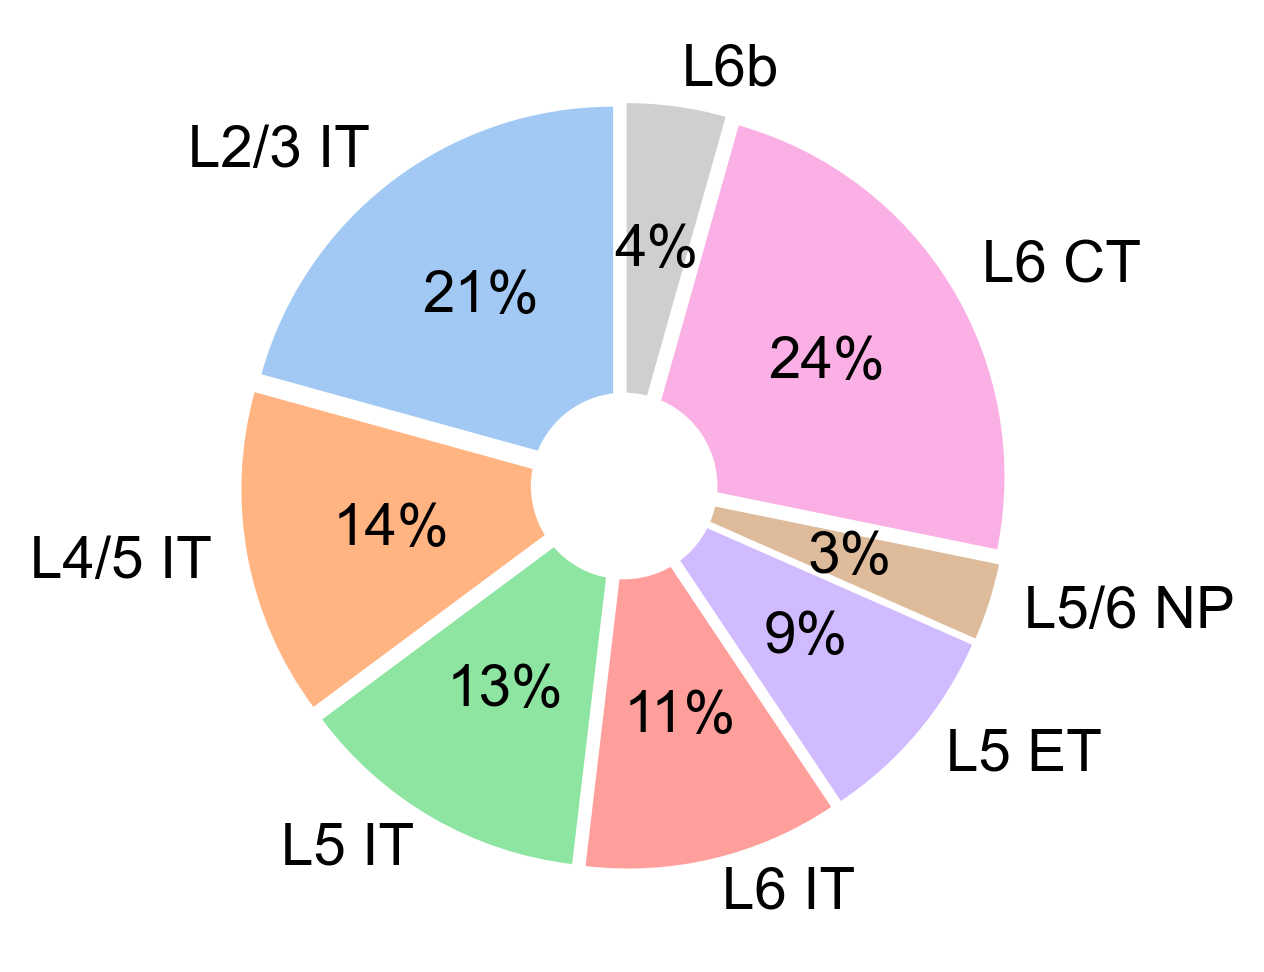

In [109]:
# 

cell_to_plot = ['L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b']


cell_num = [cellgroup_num_dict[_type] for _type in cell_to_plot]

# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')

explode_list = [0.05]*len(cell_to_plot)

# create pie chart using matplotlib
plt.pie(cell_num, labels=cell_to_plot, colors=colors,startangle=90, autopct='%1.0f%%',
        explode=explode_list,textprops={'fontsize': 14})

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.25, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.rcParams.update({'font.size': 5})

plt.show()

In [110]:
merged_cellgroup_num_dict = {'Gluta':0,'GABA':0,'Non-neuronal':0}


for _type, _num in cellgroup_num_dict.items():
    
    if _type in ['L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b']:
        merged_cellgroup_num_dict['Gluta']+=cellgroup_num_dict[_type]
        
    elif _type in ['Lamp5','Sncg','Vip','Sst','Pvalb']:
        merged_cellgroup_num_dict['GABA']+=cellgroup_num_dict[_type]
        
    elif _type in ['Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro']:
        merged_cellgroup_num_dict['Non-neuronal']+=cellgroup_num_dict[_type]
        
        
merged_cellgroup_num_dict        

{'Gluta': 29147, 'GABA': 4631, 'Non-neuronal': 26235}

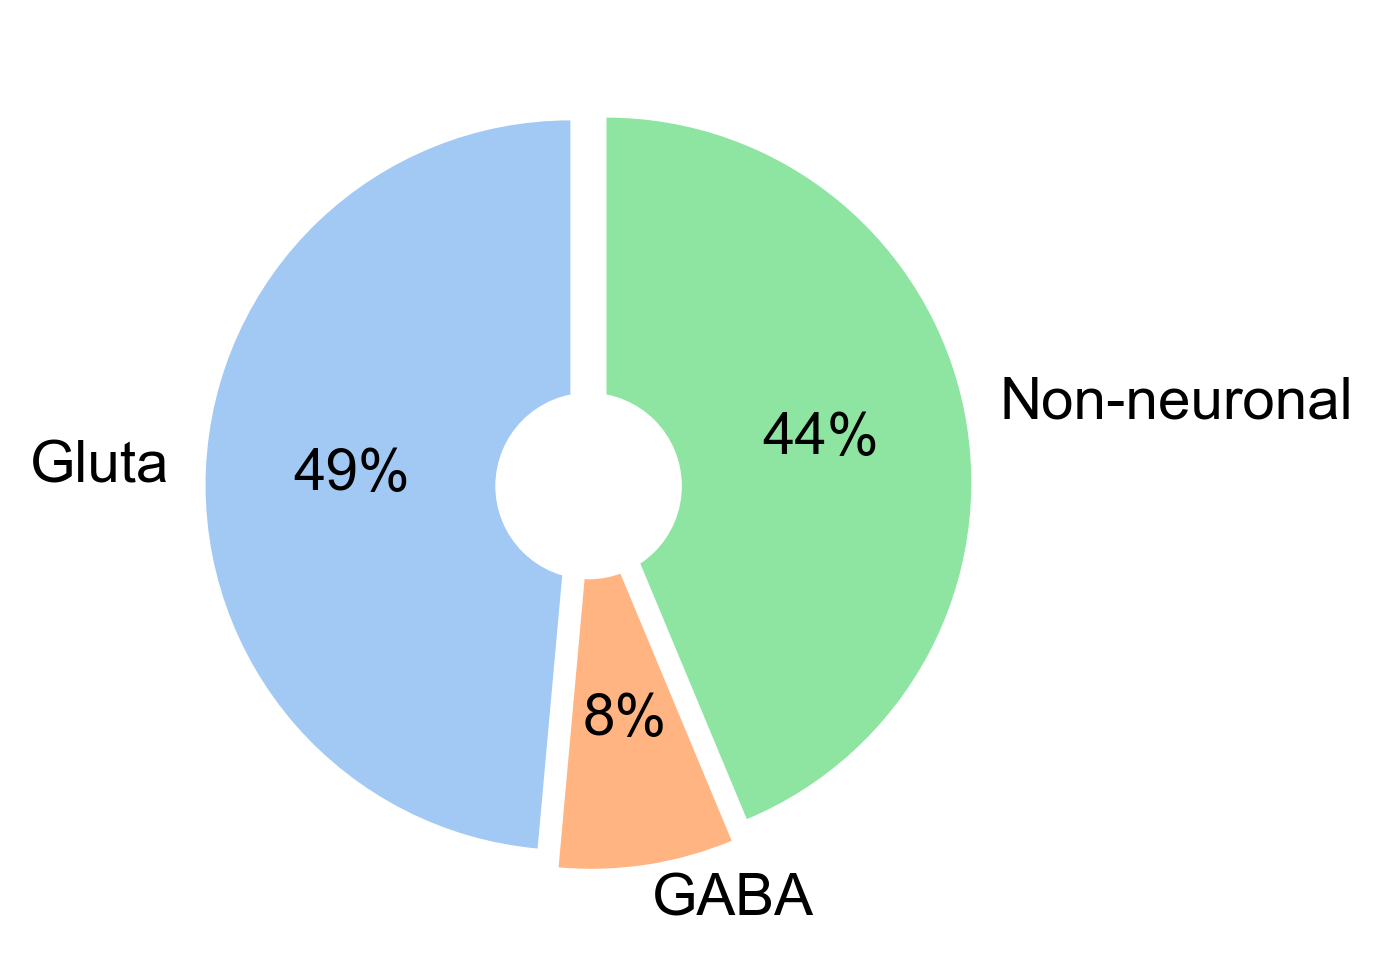

In [112]:

cell_to_plot = merged_cellgroup_num_dict.keys()


cell_num = merged_cellgroup_num_dict.values()

# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')

explode_list = [0.05]*len(cell_to_plot)

# create pie chart using matplotlib
plt.pie(cell_num, labels=cell_to_plot, colors=colors,startangle=90, autopct='%1.0f%%',
        explode=explode_list,textprops={'fontsize': 14})

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.25, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.rcParams.update({'font.size': 5})

plt.show()

## Check spatial distribution

20220418


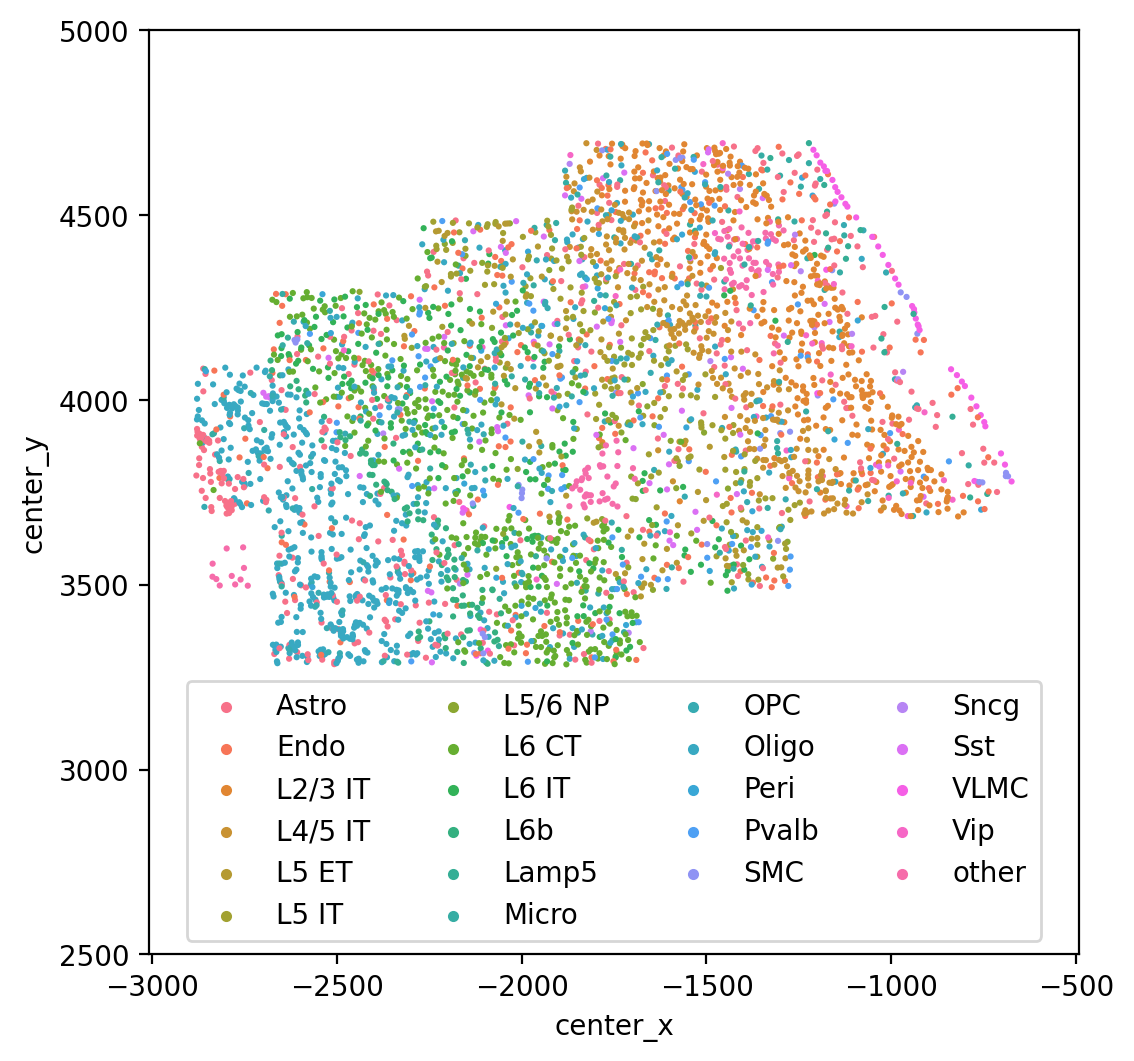

In [118]:
# scatter plot for distributions
plt.style.use('default')

experiments = np.unique(merged_adata.obs['experiment'])
sel_exp_id = 3
print(experiments[sel_exp_id])
sel_obs = merged_adata.obs.loc[merged_adata.obs['experiment']==experiments[sel_exp_id]]

# visualzie the spatial dist for clusters
#plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
ax = sns.scatterplot(data=sel_obs, x='center_x', y='center_y', 
                hue='subclass_manual_label', s=5, legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
plt.xlim([-3000,-500])
plt.ylim([2500, 5000])

hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=4, loc=8, fontsize=10, markerscale=0.5, scatterpoints=1)
plt.savefig(os.path.join(figure_folder, f'celltype_scatter_all_exp-{experiments[sel_exp_id]}.pdf'), 
            dpi=300, transparent=True)
plt.show()

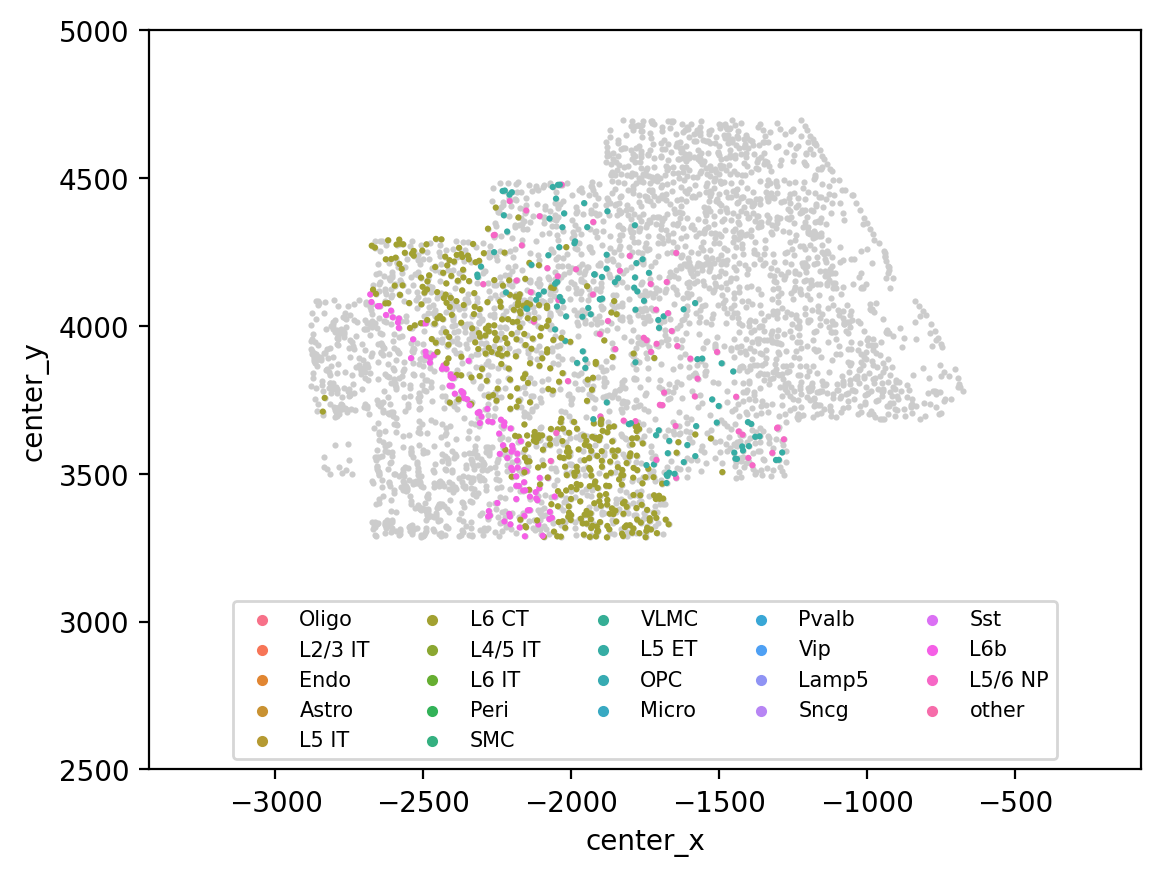

In [303]:
ExciteTypes = ['L5 ET', 'L5/6 NP', 'L6 CT', 'L6b']

sel_inds = [_i for _i, _cls in zip(sel_obs.index, sel_obs['subclass_manual_label']) if _cls in ExciteTypes]

ax1 = sns.scatterplot(data=sel_obs, x='center_x', y='center_y', 
                      color=[0.8,0.8,0.8], s=5, legend=True, linewidth=0)

ax = sns.scatterplot(data=sel_obs.loc[sel_inds], x='center_x', y='center_y', 
                hue='subclass_manual_label', s=5, legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
plt.xlim([-3000,-500])
plt.ylim([2500, 5000])

hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=4, loc=8, fontsize=10, markerscale=0.5, scatterpoints=1)
plt.savefig(os.path.join(figure_folder, f'celltype_scatter_excite_exp-{experiments[sel_exp_id]}.pdf'), transparent=True)
plt.show()

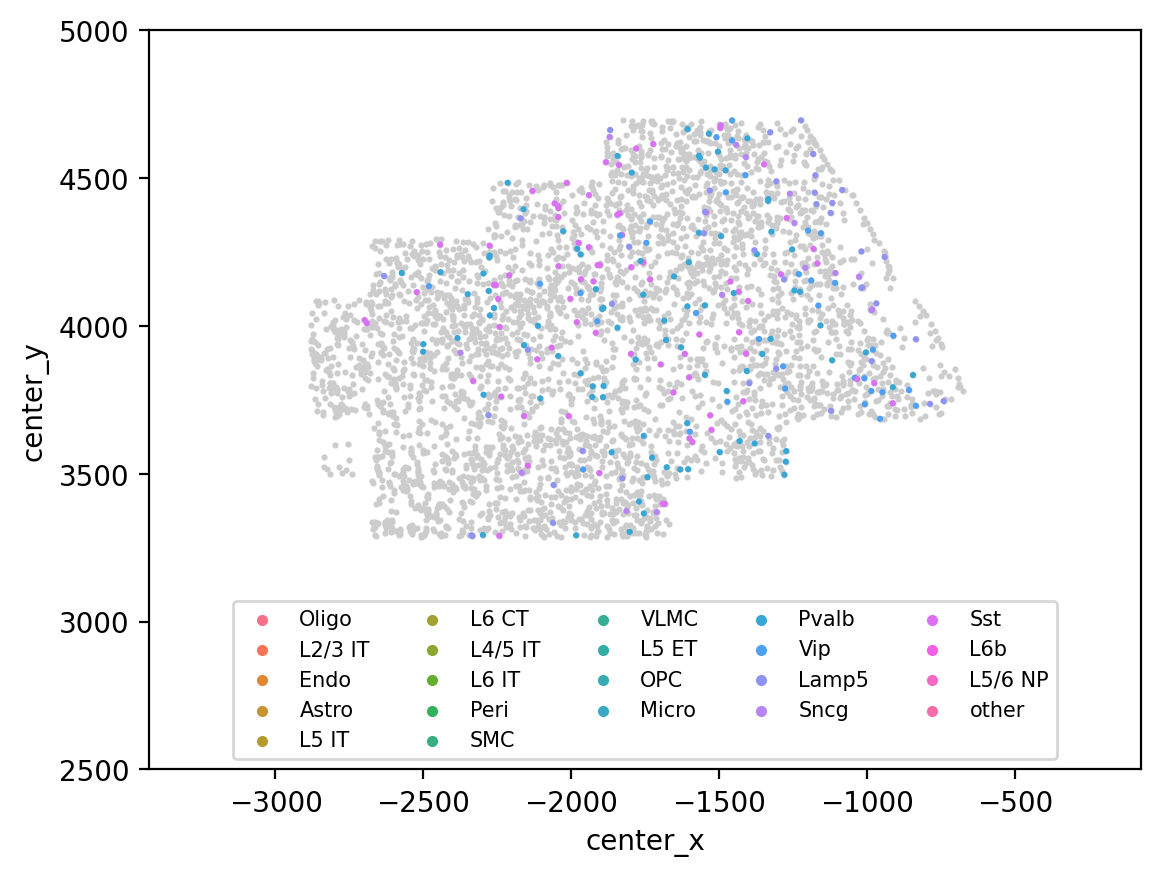

In [304]:
InhbitTypes = ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']

sel_inds = [_i for _i, _cls in zip(sel_obs.index, sel_obs['subclass_manual_label']) if _cls in InhbitTypes]

ax1 = sns.scatterplot(data=sel_obs, x='center_x', y='center_y', 
                      color=[0.8,0.8,0.8], s=5, legend=True, linewidth=0)

ax = sns.scatterplot(data=sel_obs.loc[sel_inds], x='center_x', y='center_y', 
                hue='subclass_manual_label', s=5, legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
plt.xlim([-3000,-500])
plt.ylim([2500, 5000])

hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=5, loc=8, fontsize=7.5, markerscale=0.5, scatterpoints=1)
plt.savefig(os.path.join(figure_folder, f'celltype_scatter_inhibit_exp-{experiments[sel_exp_id]}.pdf'), transparent=True)
plt.show()

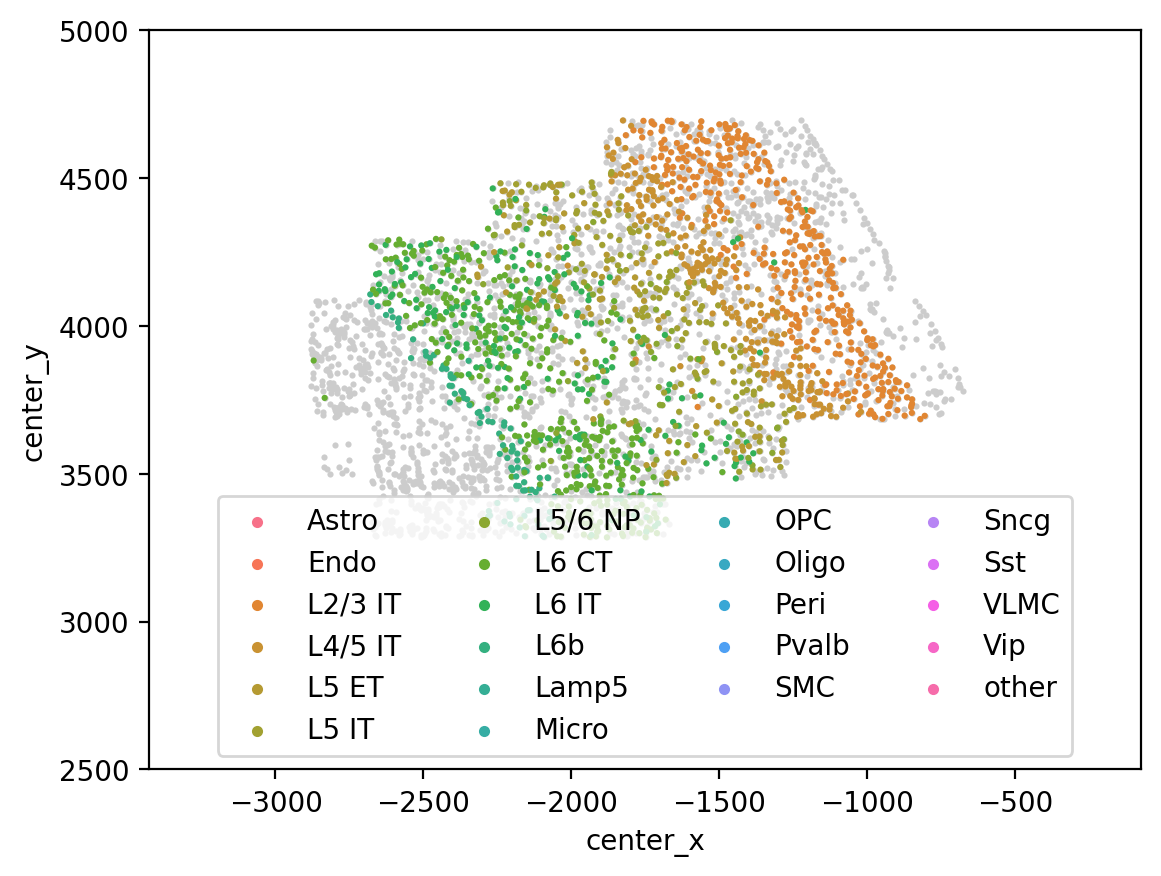

In [120]:
ITTypes = ['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT','L5 ET', 'L5/6 NP', 'L6 CT', 'L6b']

sel_inds = [_i for _i, _cls in zip(sel_obs.index, sel_obs['subclass_manual_label']) if _cls in ITTypes]

ax1 = sns.scatterplot(data=sel_obs, x='center_x', y='center_y', 
                      color=[0.8,0.8,0.8], s=5, legend=True, linewidth=0)

ax = sns.scatterplot(data=sel_obs.loc[sel_inds], x='center_x', y='center_y', 
                hue='subclass_manual_label', s=5, legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
plt.xlim([-3000,-500])
plt.ylim([2500, 5000])

hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=4, loc=8, fontsize=10, markerscale=0.5, scatterpoints=1)
plt.savefig(os.path.join(figure_folder, f'celltype_scatter_IT_exp-{experiments[sel_exp_id]}.pdf'), transparent=True)
plt.show()

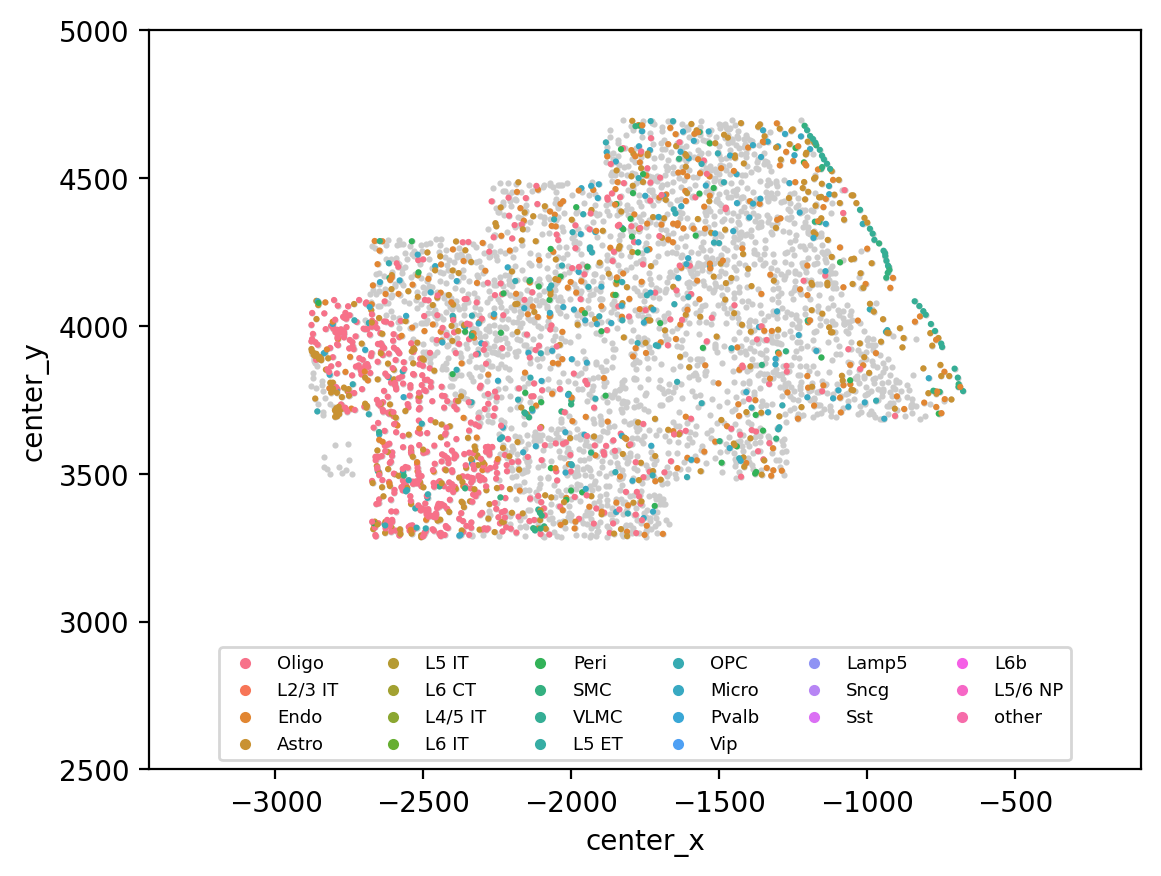

In [306]:
nonNeuTypes = ['Astro', 'Endo', 'Micro', 'OPC', 'Oligo', 'Peri', 'SMC', 'VLMC',]

sel_inds = [_i for _i, _cls in zip(sel_obs.index, sel_obs['subclass_manual_label']) if _cls in nonNeuTypes]

ax1 = sns.scatterplot(data=sel_obs, x='center_x', y='center_y', 
                      color=[0.8,0.8,0.8], s=5, legend=True, linewidth=0)

ax = sns.scatterplot(data=sel_obs.loc[sel_inds], x='center_x', y='center_y', 
                hue='subclass_manual_label', s=5, legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
plt.xlim([-3000,-500])
plt.ylim([2500, 5000])

hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=6, loc=8, fontsize=6.5, markerscale=0.5, scatterpoints=1)
plt.savefig(os.path.join(figure_folder, f'celltype_scatter_nonNeu_exp-{experiments[sel_exp_id]}.pdf'), transparent=True)
plt.show()

In [123]:
len(merged_adata)

62732

# 4. Save newly labeled data

In [37]:
save_filename = os.path.join(os.path.join(save_folder, 'new_labeled_data.h5ad'))

overwrite = True

if not os.path.exists(save_filename) or overwrite:
    print(f"save merged_adata into file: {save_filename}")
    merged_adata.write(save_filename)
else:
    print(f"savefile: {save_filename} already exists")

save merged_adata into file: L:\Shiwei\RNA_MERFISH_analysis\Merged_nonclear\new_labeled_data.h5ad
